<a href="https://colab.research.google.com/github/jecampagne/Jemu/blob/main/jemu_pklinZ0_demo_GoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip -q install jax_cosmo

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [7]:
! git clone https://github.com/jecampagne/Jemu.git

Cloning into 'Jemu'...
remote: Enumerating objects: 21039, done.
remote: Counting objects: 100% (4963/4963), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 21039 (delta 4851), reused 4920 (delta 4816), pack-reused 16076
Receiving objects: 100% (21039/21039), 513.41 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (20207/20207), done.
Checking out files: 100% (5068/5068), done.


In [8]:
cd /content/gdrive/MyDrive/Jemu

/content/gdrive/MyDrive/Jemu


In [26]:
# In case Pyccl is needed : a bit long...
#!pip install -q condacolab
#import condacolab
#condacolab.install()
#!mamba install pyccl
#! pip install -q  classy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.1/639.1 kB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for classy: filename=classy-2.9.4.0-cp37-cp37m-linux_x86_64.whl size=1892278 sha256=b87262b5125a5aca17624995dd1fa62d259a6b5181edd09d2093374e3a52d1c1
  Stored in directory: /root/.cache/pip/wheels/12/02/34/38a71e6c87f8a8af6fba4a950e71ec38e9fcfed846662d9a0f
Successfully built classy


In [10]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.80'

import numpy as np
import jax
import jax.numpy as jnp
import jax_cosmo as jc      # Jax-cosmo lib
#import pyccl as ccl         # CCL python      # just to make a plot
import jemupk  as emu  # Jax Emulator of CLASS

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
import matplotlib.patches as mpatches
mpl.rcParams['font.size'] = 16

# Jemu parameters

In [12]:
import settings_gfpkq_120x20  as st         # configuration file (update 2/June/22)
print(f"(k,z)-grid: {st.nk}x{st.nz}")

(k,z)-grid: 120x20


In [13]:
root_dir = "./"
if st.sigma8:
    print("Using: Omega_cdm, Omega_b, sigma8, ns, h")
    tag='_Omega_sig8_'  + str(st.nk) + "x" + str(st.nz)  
else:
    raise NotImplementedError("non-sigma8 parameter set no more in use")

load_dir = root_dir + '/pknl_components' + st.d_one_plus+tag

Using: Omega_cdm, Omega_b, sigma8, ns, h


In [14]:
# load GP material
gp_factory = emu.GP_factory.load_gps(directory=load_dir,gp_names=["Pklin0"])

In [15]:
assert len(gp_factory["pl"]) == st.nk

In [16]:
assert emu.GP_factory.done

# Define a cosmology parameter set

In [17]:
h_emu = 0.6774 
Omega_c_emu = 0.2589
Omega_b_emu = 0.0486
sigma8_emu = 0.8159
n_s_emu = 0.9667


In [18]:
#jax-cosmo cosmology init
cosmo_jax = jc.Cosmology(Omega_c=Omega_c_emu, Omega_b=Omega_b_emu, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Omega_k=0.0, w0=-1.0,wa=0.0)

In [20]:
#ccl boltzmann_class
#cosmo_ccl_bc = ccl.Cosmology(
#    Omega_c=Omega_c_emu, Omega_b=Omega_b_emu, 
#    h=h_emu, n_s=n_s_emu, sigma8 = sigma8_emu,
#    transfer_function='boltzmann_class', matter_power_spectrum='halofit')


In [21]:
Nk=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.k_max_h_by_Mpc, Nk, endpoint=True) #h/Mpc
kgrid = emu.jemu_st.k_train

In [22]:
pk_linear_kstar = emu.linear_pk_z0(cosmo_jax, k_star)

In [27]:
#pk_lin_ccl_bc = ccl.linear_matter_power(cosmo_ccl_bc, k_star*cosmo_jax.h, 1.) #last is scale factor 1=>z=0

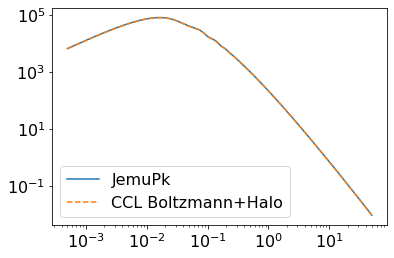

In [29]:
plt.plot(k_star,pk_linear_kstar, label="JemuPk")
#plt.plot(k_star,pk_lin_ccl_bc, label="CCL Boltzmann+Halo", ls="--")
plt.yscale("log")
plt.xscale("log")
plt.legend();

In [30]:
# The fist call triggers the XLA compilation.
func_pklin = lambda p: emu.linear_pk_z0(p,k_star)
jac_pklin = jax.jacfwd(func_pklin)(cosmo_jax)

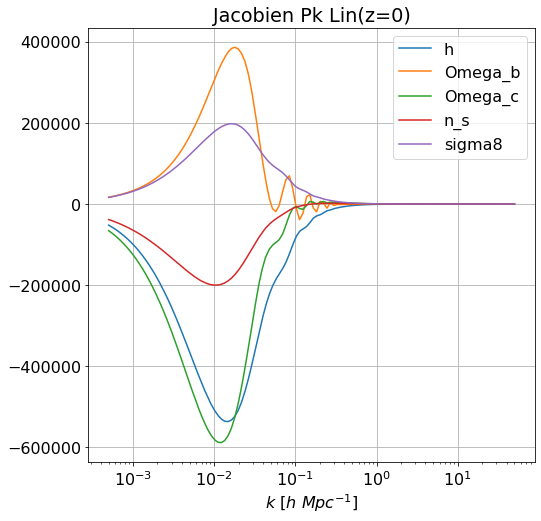

In [36]:
# Omega_c, Omega_b, h, n_s, sigma8, Omega_k, w0, wa, gamma=None
titles=f"Jacobien Pk Lin(z=0)"
lines=["-","--"]
colors=[None,"k"]
fig = plt.figure(figsize=(8,8))
for i,jaco in enumerate([jac_pklin]):
    plt.plot(k_star,jaco.h,label="h",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.Omega_b,label="Omega_b",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.Omega_c,label="Omega_c",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.n_s,label="n_s",c=colors[i],ls=lines[i])
    plt.plot(k_star,jaco.sigma8,label="sigma8",c=colors[i],ls=lines[i])
    if i == 0:
        plt.legend();
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")
plt.xscale("log")
plt.title(titles)
plt.grid()